# Apartment Pricing Model
Based on the [data set](https://www.kaggle.com/mrdaniilak/russia-real-estate-20182021) containing **listings of apartments** offered for sale in various regions . I develop a pricing models that could be used to evaluate apartments located in the **city **. Similar approach could be used to create regression models for other regions.

**Models used:** XGBoost, LGBM, CatBoost

**Techniques applied:** data cleaning, filtering outliers, feature engineering

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [2]:
import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH = 'all_v2.csv'

REGION_ID = 2661  # City of Saint Petersburg

MIN_AREA = 20  # Outlier range for floor area
MAX_AREA = 200

MIN_KITCHEN = 6  # Outlier range for kitchen area
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Outlier range for price
MAX_PRICE = 50_000_000

SEED = 15
N_FOLDS = 5

## Functions

In [4]:
def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Function removes excess columns and enforces
    correct data types.
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    df.drop('time', axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # Column actually contains -1 and -2 values presumably for studio apartments.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    df['price'] = df['price'].abs()  # Fix negative values
    # Drop price and area outliers.
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    # Fix kitchen area outliers.
    # At first, replace all outliers with 0.
    df.loc[(df['kitchen_area'] >= MAX_KITCHEN) | (df['area'] <= MIN_AREA), 'kitchen_area'] = 0
    # Then calculate kitchen area based on the floor area, except for studios.
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'kitchen_area'] = \
        df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'area'] * kitchen_share

    return df


def select_region(df: pd.DataFrame) -> pd.DataFrame:
    """Function selects the listings belonging to a specified region.
    :param df: Original DataFrame with all listings
    :return: Filtered DataFrame
    """
    df = df[df['region'] == REGION_ID]
    df.drop('region', axis=1, inplace=True)
    print(f'Selected {len(df)} samples in region {REGION_ID}.')
    return df


def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Replace "date" with numeric features for year and month.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    # Apartment floor in relation to total number of floors.
    df['level_to_levels'] = df['level'] / df['levels']
    # Average size of room in the apartment.
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    # Fix division by zero.
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    return df


def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Data Analysis

In [5]:
set_display()

In [6]:
data = pd.read_csv(PATH)
print(f'Data shape: {data.shape}')
data.head()

Data shape: (5477006, 13)


,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.8058,30.3761,2661,1,8,10,3,82.6000,10.8000,1
1,8650000,2018-02-27,12:04:54,55.6838,37.2974,81,3,5,24,2,69.1000,12.0000,1
2,4000000,2018-02-28,15:44:00,56.2953,44.0616,2871,1,5,9,3,66.0000,10.0000,1
3,1850000,2018-03-01,11:24:52,44.9961,39.0748,2843,4,12,16,2,38.0000,5.0000,11
4,5450000,2018-03-01,17:42:43,55.9188,37.9846,81,3,13,14,2,60.0000,10.0000,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


In [8]:
data.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000
mean,4422029.0229,54.0383,53.2443,4307.1409,1.9490,6.2145,11.3989,1.7262,53.9182,10.6284,3.9454
std,21507519.1548,4.6228,20.7476,3308.0502,1.0385,4.9574,6.5357,1.0821,33.3529,9.7924,4.5584
min,-2144967296.0000,41.4591,19.8902,3.0000,0.0000,1.0000,1.0000,-2.0000,0.0700,0.0100,1.0000
25%,1950000.0000,53.3777,37.7779,2661.0000,1.0000,2.0000,5.0000,1.0000,38.0000,7.0000,1.0000
50%,2990000.0000,55.1714,43.0677,2922.0000,2.0000,5.0000,10.0000,2.0000,48.0200,9.7000,1.0000
75%,4802000.0000,56.2261,65.6489,6171.0000,3.0000,9.0000,16.0000,2.0000,63.1300,12.7000,11.0000
max,2147483647.0000,71.9804,162.5361,61888.0000,5.0000,39.0000,39.0000,10.0000,7856.0000,9999.0000,11.0000


Data set contains samples with typos and errors including negative prices, too large or unrealistically small floor area, etc. Let's clean the data before proceeding with the analysis. We limit the floor area to a range betwee 20 sq.m and 200 sq.m and price to a range between 1.5 mln to 50 mln rubles, which covers most of the housing market.

In [9]:
data = data.pipe(clean_data)
data.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.8058,30.3761,2661,1,8,10,3,82.6000,10.8000,1
1,8650000,2018-02-27,55.6838,37.2974,81,3,5,24,2,69.1000,12.0000,1
2,4000000,2018-02-28,56.2953,44.0616,2871,1,5,9,3,66.0000,10.0000,1
3,1850000,2018-03-01,44.9961,39.0748,2843,4,12,16,2,38.0000,5.0000,11
4,5450000,2018-03-01,55.9188,37.9846,81,3,13,14,2,60.0000,10.0000,1


### Features and data types
- Categorical features:
  - Region (numerically encoded geographical area, identifies either a large city like Moscow or Saint Petersburg or a federal region / district)
  - Building type (numerically encoded type of the building where the apartment is located)
  - Object type (apartment type, where 1 stands for secondary real estate market, 11 - new building)
- Numerical features:
  - Area (total floor area of the apartment in sq. meters)
  - Kitchen area (kitchen area in sq. meters)
  - Rooms (number of rooms in the apartment, -1 stands for studios with open-space layout)
  - Level (floor the apartment is located on, could be treated as a categorical feature as well)
  - Levels (total number of storeys in the building)
- Geospatial features:
  - Latitude - geographical coordinate of the preperty
  - Longitude - geographical coordinate of the preperty
- Temporal features:
  - Date (date the listing was published)
  - Time (exact time the listing was published)

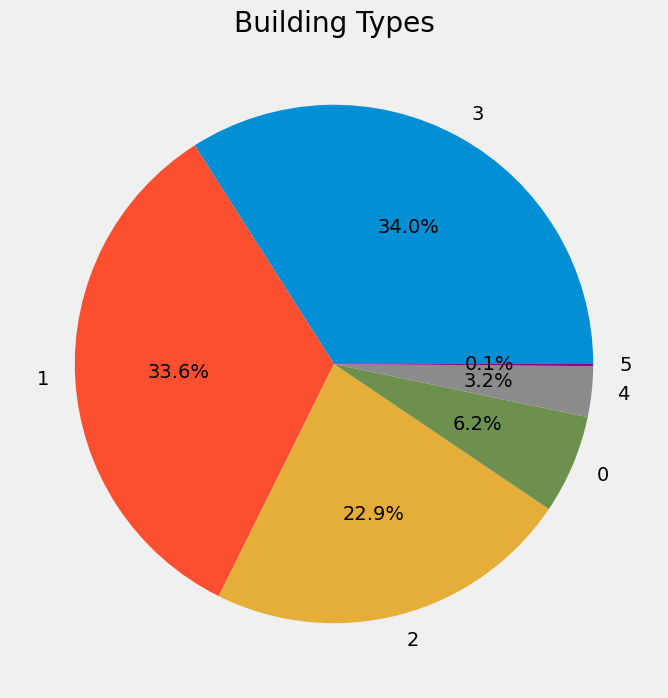

In [10]:
building_types = data['building_type'].value_counts()
plt.pie(building_types.values, labels=building_types.index, autopct='%1.1f%%')
plt.title('Building Types')
plt.show()

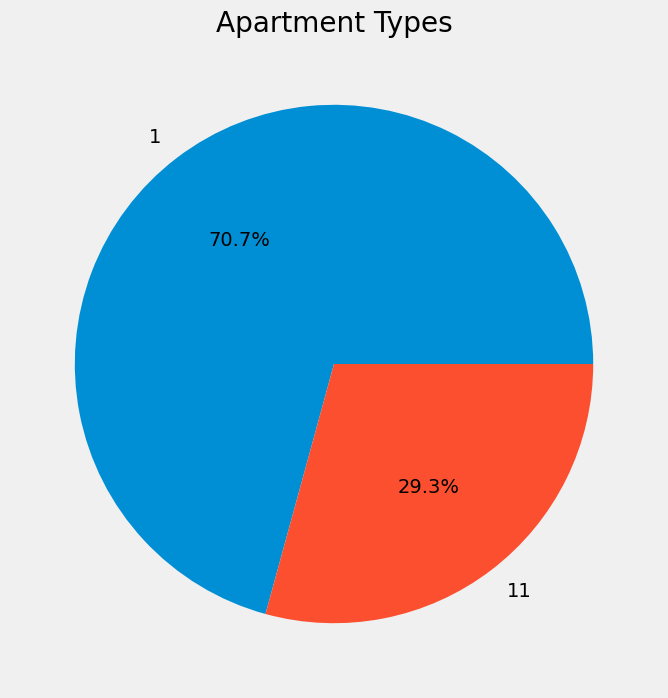

In [11]:
apartment_types = data['object_type'].value_counts()
plt.pie(apartment_types.values, labels=apartment_types.index, autopct='%1.1f%%')
plt.title('Apartment Types')
plt.show()

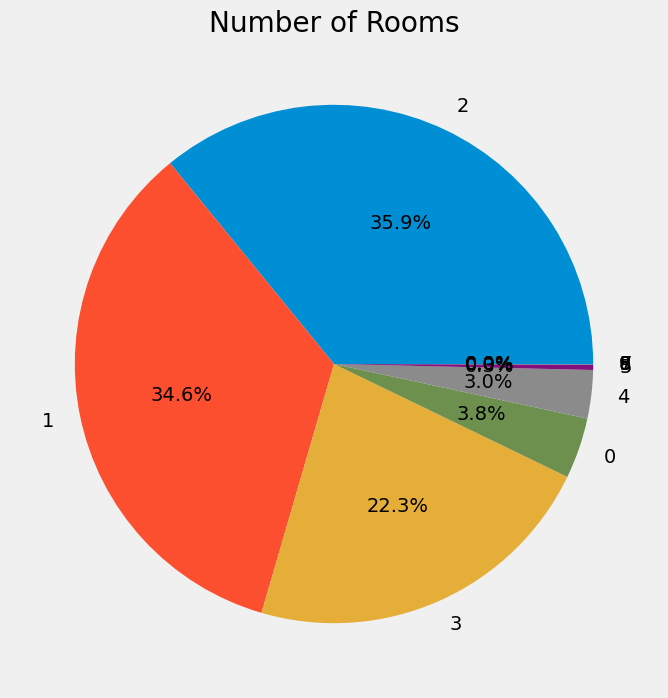

In [12]:
rooms = data['rooms'].value_counts()
plt.pie(rooms.values, labels=rooms.index, autopct='%1.1f%%')
plt.title('Number of Rooms')
plt.show()

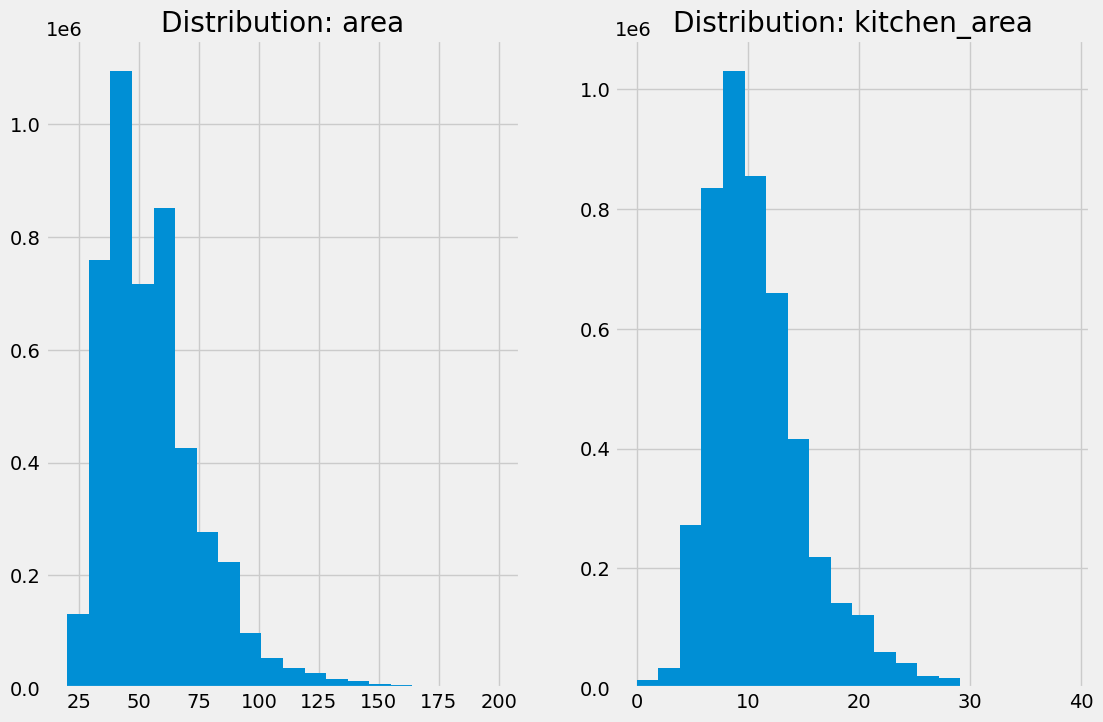

In [13]:
pos = 0
for pos, feature in enumerate(['area', 'kitchen_area']):
    sp = plt.subplot(1, 2, pos + 1)
    plt.hist(data[feature], bins=20)
    plt.title(f'Distribution: {feature}')
plt.show()

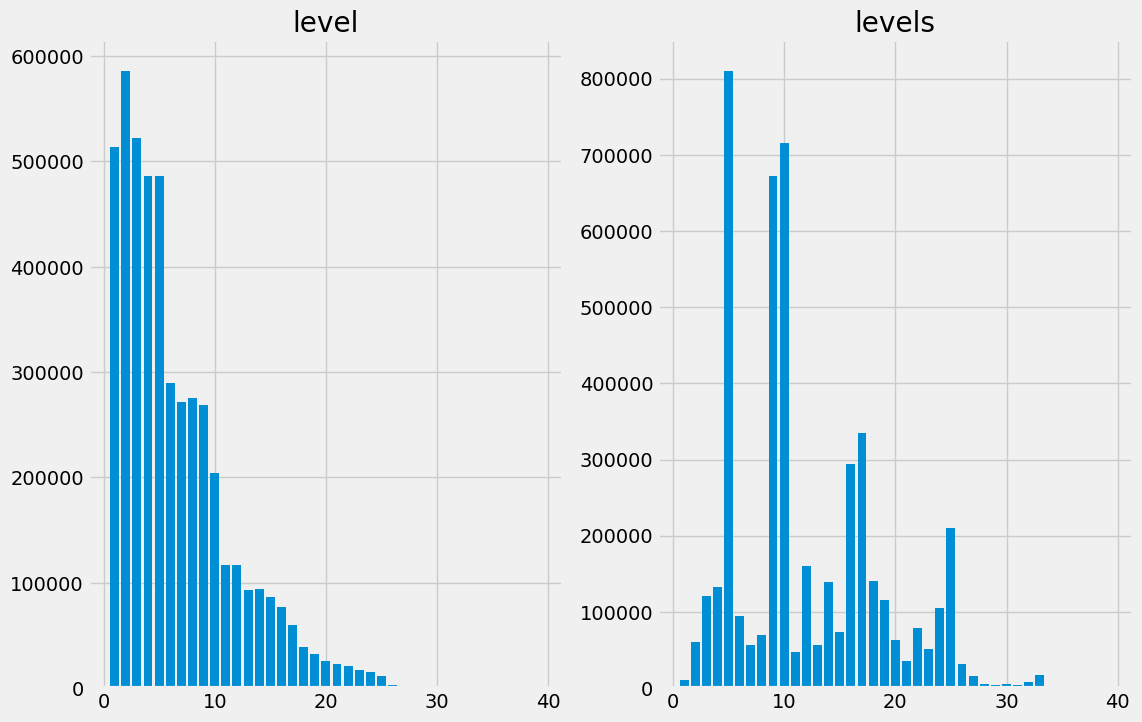

In [14]:
pos = 0
for pos, feature in enumerate(['level', 'levels']):
    levels = data[feature].value_counts()
    sp = plt.subplot(1, 2, pos + 1)
    plt.bar(levels.index, levels.values)
    plt.title(feature)
plt.show()

9654    812372
2843    575693
81      480497
2661    453621
3       411225
2922    213368
6171    205363
3230    196428
3991    132777
5282    103757
Name: region, dtype: int64


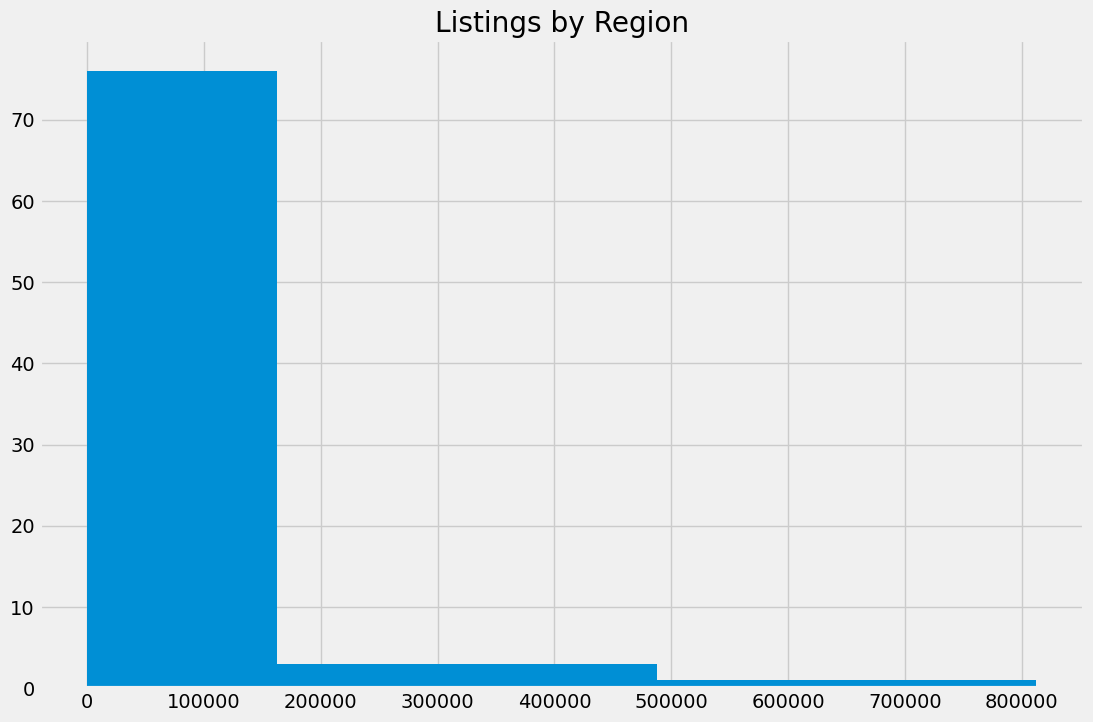

In [15]:
# Regions are encoded with numeric IDs.
regions = data['region'].value_counts()
print(regions.head(10))

plt.hist(regions.values, bins=5)
plt.title('Listings by Region')
plt.show()

Listings are unequally distributed between the regions with most of the offerings concentrated in the largest and most developed cities and their surrounding areas.

In [16]:
# Find out what regions are represented in the data set.
for region in data['region'].unique():
    subset = data[data['region'] == region]
    lat, lon = np.round(subset[['geo_lat', 'geo_lon']].mean(), 2)
    print(f'Region {region}: latitude = {lat}, longitude = {lon}')

Region 2661: latitude = 59.93, longitude = 30.32
Region 81: latitude = 55.73, longitude = 37.77
Region 2871: latitude = 56.24, longitude = 43.91
Region 2843: latitude = 44.86, longitude = 38.88
Region 3: latitude = 55.72, longitude = 37.58
Region 3106: latitude = 53.25, longitude = 50.08
Region 2922: latitude = 55.75, longitude = 49.91
Region 2722: latitude = 54.61, longitude = 55.76
Region 3230: latitude = 47.27, longitude = 39.73
Region 4417: latitude = 62.41, longitude = 51.94
Region 5282: latitude = 55.08, longitude = 61.2
Region 5368: latitude = 53.14, longitude = 103.66
Region 3446: latitude = 59.99, longitude = 30.41
Region 5520: latitude = 58.03, longitude = 56.19
Region 6171: latitude = 56.88, longitude = 60.6
Region 9579: latitude = 51.92, longitude = 107.65
Region 1010: latitude = 56.91, longitude = 53.26
Region 9648: latitude = 43.5, longitude = 43.61
Region 2604: latitude = 57.62, longitude = 39.77
Region 3019: latitude = 56.11, longitude = 47.27
Region 4982: latitude = 56

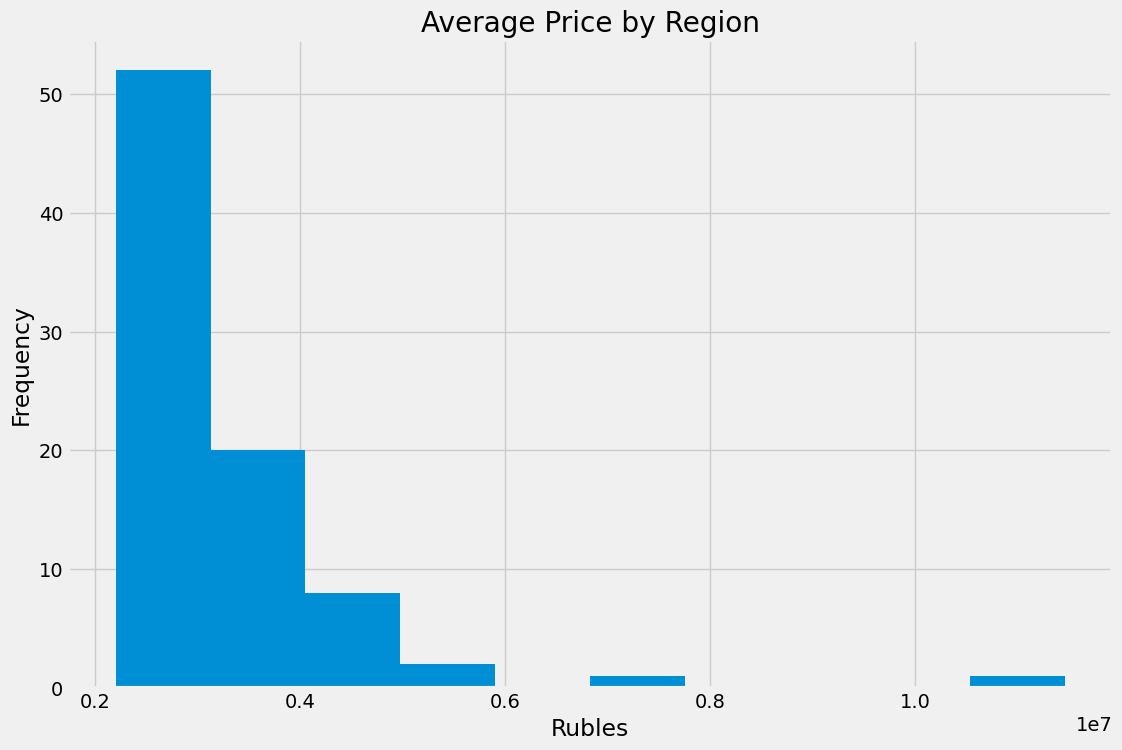

In [17]:
avg_prices = data.groupby(by='region')['price'].mean()
plt.hist(avg_prices.values, bins=10)
plt.xlabel('Rubles')
plt.ylabel('Frequency')
plt.title('Average Price by Region')
plt.show()

Knowing the basics of real estate pricing, it's unreasonable to develop a single model for all the regions. Pricing factors could have different impact on the actual price depending on the region, local market conditions, prevailing types of buildings in the area, etc.

A number of important features are missing in this data set, which would lead to larger errors regardless of applied regression algorithms and quality of the model:
- Condition: similar apartments would be priced differently, if one of them is being sold fully furnished in excellent condition and the other is being sold without finishing.
- Ceiling height affects the price.
- Balconies and terraces increase the price compared to similar apartments without such menities.
- Additional unique properties usually mentioned in the description of the apartment, like chimneys or underground parking spaces, affect the price.

Taking that in mind we will try to develop a pricing model for apartments located in Saint Petersburg.

## Feature Engineering

In [18]:
data = data.pipe(select_region)
data = data.pipe(add_features)
data.head()

Selected 453621 samples in region 2661.


,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
0,6050000,59.8058,30.3761,1,8,10,3,82.6000,10.8000,1,2018,2,0.8000,27.5333
7,3600000,59.8755,30.3955,1,2,5,1,31.1000,6.0000,1,2018,3,0.4000,31.1000
36,3200000,59.8275,30.2018,1,7,9,1,31.0000,7.0000,1,2018,4,0.7778,31.0000
47,6500000,59.9883,29.7869,3,3,3,3,89.0000,10.0000,1,2018,4,1.0000,29.6667
54,6300000,59.9116,30.2846,3,5,5,2,99.9000,14.5000,1,2018,4,1.0000,49.9500


In [19]:
gc.collect()

21288

In [20]:
data.describe()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
count,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000,453621.0000
mean,7663511.1338,59.9327,30.3196,1.9443,7.6222,14.4329,1.8193,57.0727,12.1962,5.3045,2019.5454,6.5346,0.5435,32.6040
std,5601934.2405,0.0850,0.1206,0.9523,5.7030,7.0618,0.9760,26.6006,5.1952,4.9514,0.8555,3.4328,0.2822,9.8309
min,1500000.0000,59.6474,29.5093,0.0000,1.0000,1.0000,0.0000,20.0000,0.0000,1.0000,2018.0000,1.0000,0.0323,2.8750
25%,4437600.0000,59.8631,30.2568,1.0000,3.0000,9.0000,1.0000,37.7000,8.5000,1.0000,2019.0000,3.0000,0.3000,26.0000
50%,5940000.0000,59.9391,30.3243,2.0000,6.0000,13.0000,2.0000,50.9000,11.1000,1.0000,2020.0000,7.0000,0.5385,31.5500
75%,8711033.0000,60.0003,30.3995,3.0000,11.0000,21.0000,2.0000,68.1000,15.0000,11.0000,2020.0000,10.0000,0.7895,37.5000
max,50000000.0000,60.2420,30.7114,5.0000,35.0000,38.0000,9.0000,200.0000,38.8350,11.0000,2021.0000,12.0000,4.0000,198.0000


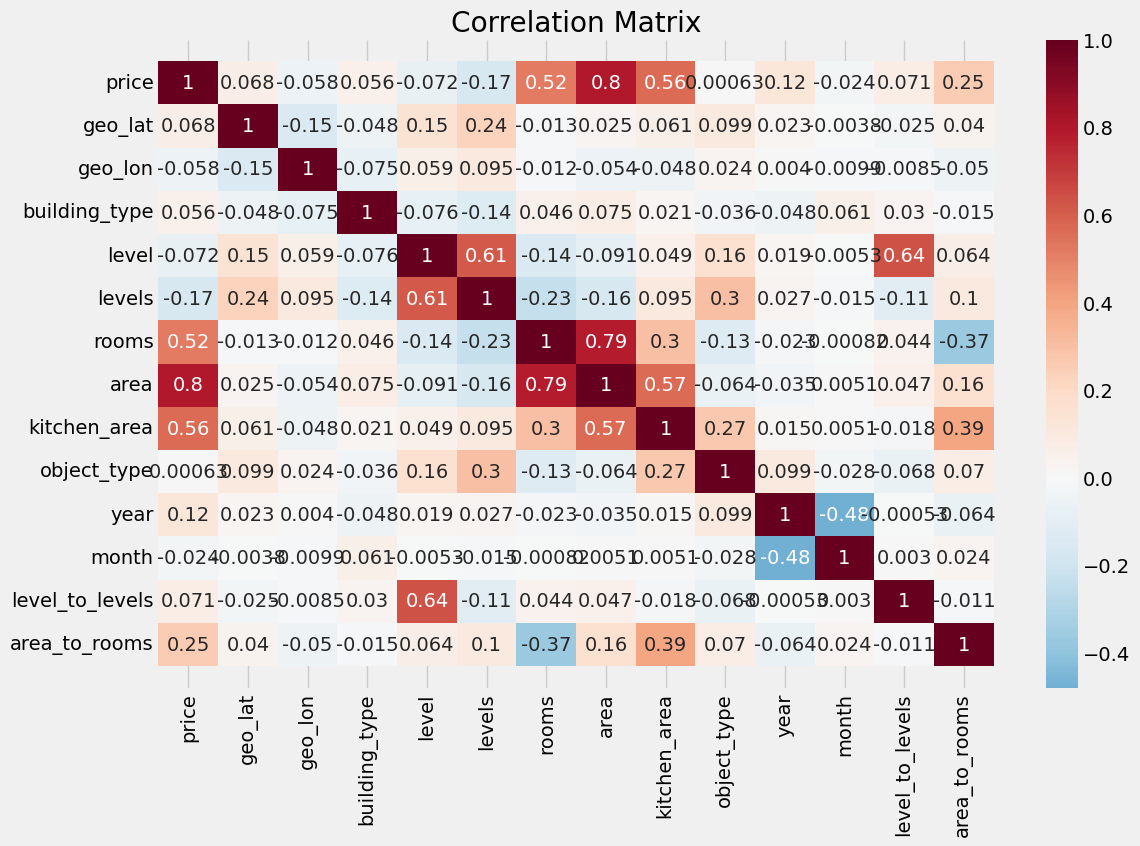

In [23]:
correlation = data.corr()
ax = sns.heatmap(correlation,annot=True, center=0, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()

In [24]:
y = data.pop('price')

## Models Cross-Validation

In [25]:
set_seed(SEED)

kf = KFold(N_FOLDS, shuffle=True, random_state=SEED)

### XGBoost Model

In [26]:
scores = []

for train_index, test_index in kf.split(data, y):

    x_train, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_xgb = XGBRegressor(objective='reg:squarederror')

    model_xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                  eval_metric='rmse', early_stopping_rounds=50,
                  verbose=0)

    scores.append(model_xgb.best_score)
    model_xgb.save_model(f'xgboost{len(scores)}.bin')

print('XGBoost average RMSE:', np.mean(scores))
for i, score in enumerate(scores):
    print(f'Model {i} RMSE: {score}')

XGBoost average RMSE: 1797066.0733262326
Model 0 RMSE: 1819131.1313789757
Model 1 RMSE: 1814937.7868035624
Model 2 RMSE: 1779932.2057450295
Model 3 RMSE: 1798167.262757681
Model 4 RMSE: 1773161.9799459144


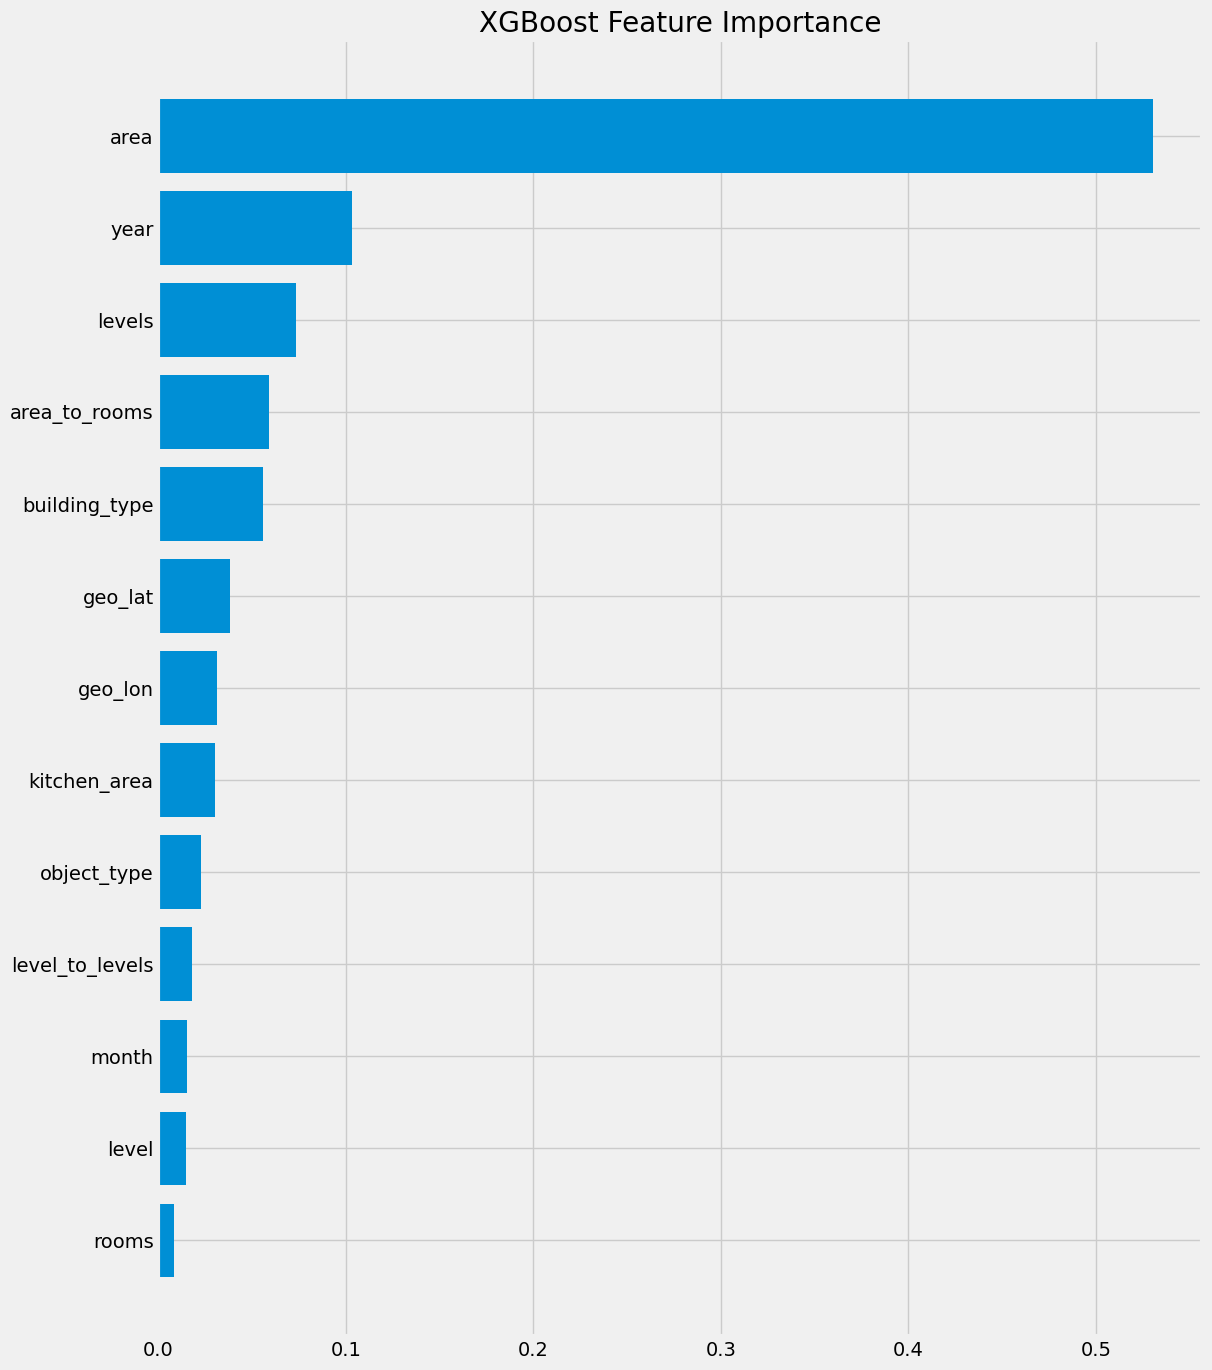

In [27]:
# Display feature importance.
importance = pd.DataFrame({
    'features': data.columns,
    'importance': model_xgb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('XGBoost Feature Importance')
plt.show()

### CatBoost Model

In [30]:
scores = []

for train_index, test_index in kf.split(data, y):

    x_train, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_cb = CatBoostRegressor(eval_metric='RMSE',
                                 cat_features=['building_type', 'object_type', 'month'])
    model_cb.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                 early_stopping_rounds=20, use_best_model=True,
                 verbose=0)

    scores.append(model_cb.best_score_['validation']['RMSE'])
    model_cb.save_model(f'catboost{len(scores)}.cbm')

print('Average RMSE:', np.mean(scores))
for i, score in enumerate(scores):
    print(f'Model {i} RMSE: {score}')

Average RMSE: 1735834.5166338545
Model 0 RMSE: 1763860.722312028
Model 1 RMSE: 1743654.0839787459
Model 2 RMSE: 1718068.9236082511
Model 3 RMSE: 1735937.8053026584
Model 4 RMSE: 1717651.0479675902


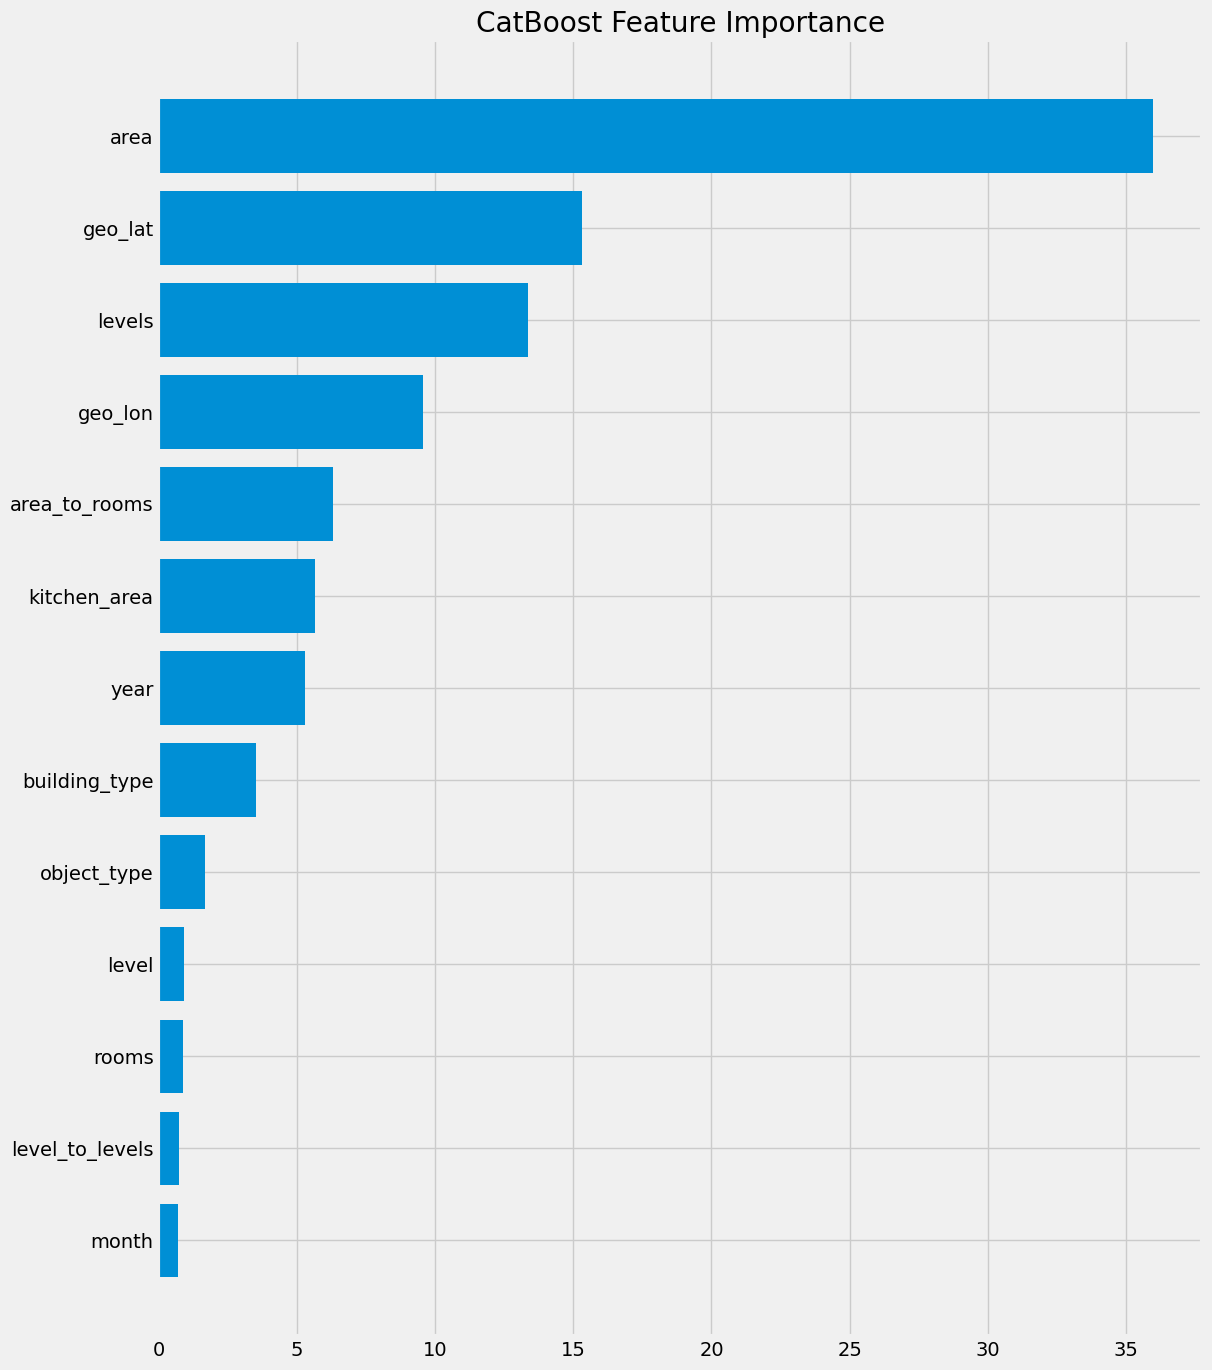

In [31]:
# Display feature importance.
importance = pd.DataFrame({
    'features': data.columns,
    'importance': model_cb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('CatBoost Feature Importance')
plt.show()

## Conclusions
Standard deviation of price in the selected subset of data representing housing market is about 5.6 mln rubles. Gradient boosting models RMSE is in the range between 1.7 and 1.9 mln rubles. There is still room for improvement taking into account that median price in the city is about 6 mln rubles. However without additional features describing condition, presence or absence of furniture and other improvements making these models significantly more accurate would be difficult.